
# Heart Disease Prediction

**Dataset:** UCI Heart Disease Dataset  
**Problem Type:** Binary Classification  

## Step 1: Imports and Configurations

In [1]:

# ============================
# Imports and Configurations
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)
plt.rcParams['figure.figsize'] = (8, 5)



## Step 2: Load Dataset


In [2]:

# Load dataset using project root structure
df = pd.read_csv("../data/heart.csv")
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0



## Step 3: Data Preprocessing


In [3]:

X = df.drop('target', axis=1).values
y = df['target'].values.reshape(-1, 1)

# Train-test split (manual)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Feature scaling (standardization)
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std



## Step 4: Logistic Regression


In [4]:

class LogisticRegression:
    def __init__(self, lr=0.01, epochs=500):
        self.lr = lr
        self.epochs = epochs
        self.train_losses = []
        self.train_accuracies = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        self.w = np.zeros((X.shape[1], 1))
        self.b = 0

        for epoch in range(self.epochs):
            z = np.dot(X, self.w) + self.b
            y_pred = self.sigmoid(z)

            loss = -np.mean(y * np.log(y_pred + 1e-9) + (1 - y) * np.log(1 - y_pred + 1e-9))

            dw = np.dot(X.T, (y_pred - y)) / len(y)
            db = np.mean(y_pred - y)

            self.w -= self.lr * dw
            self.b -= self.lr * db

            preds = (y_pred >= 0.5).astype(int)
            acc = np.mean(preds == y)

            self.train_losses.append(loss)
            self.train_accuracies.append(acc)

    def predict_proba(self, X):
        return self.sigmoid(np.dot(X, self.w) + self.b)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)



## Step 5: Model Training


In [5]:

model = LogisticRegression(lr=0.01, epochs=500)
model.fit(X_train, y_train)



## Step 6: Evaluation Metrics (All Models)


In [6]:

def compute_confusion_matrix(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return TP, TN, FP, FN

def compute_metrics(y_true, y_pred):
    TP, TN, FP, FN = compute_confusion_matrix(y_true, y_pred)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    return accuracy, precision, recall, f1, TP, TN, FP, FN

def print_evaluation(y_true, y_pred, model_name):
    acc, prec, rec, f1, TP, TN, FP, FN = compute_metrics(y_true, y_pred)
    print(f"\n{model_name} Evaluation")
    print("=" * 50)
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print("\nConfusion Matrix")
    print("            Pred 0   Pred 1")
    print(f"Actual 0     {TN:4d}     {FP:4d}")
    print(f"Actual 1     {FN:4d}     {TP:4d}")

def plot_evaluation_row(y_true, y_proba, y_pred, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # 1. Probability distribution
    axes[0].scatter(
        range(len(y_proba)),
        y_proba.flatten(),
        c=y_true.flatten(),
        cmap='bwr',
        alpha=0.6
    )
    axes[0].axhline(0.5, linestyle='--')
    axes[0].set_title(f"{title}: Predicted Probabilities")

    # 2. Confusion matrix
    TP, TN, FP, FN = compute_confusion_matrix(y_true, y_pred)
    cm = np.array([[TN, FP], [FN, TP]])

    axes[1].imshow(cm, cmap='Blues')
    axes[1].set_title(f"{title}: Confusion Matrix")

    for i in range(2):
        for j in range(2):
            axes[1].text(j, i, cm[i, j], ha='center', va='center')

    # 3. Metric summary
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if TP + FP else 0
    recall = TP / (TP + FN) if TP + FN else 0

    axes[2].bar(
        ['Accuracy', 'Precision', 'Recall'],
        [accuracy, precision, recall]
    )
    axes[2].set_ylim(0, 1)
    axes[2].set_title(f"{title}: Metrics")

    plt.tight_layout()
    plt.show()




## Step 7: Visualizations (All Models)


In [7]:

def plot_training_history(model):
    plt.figure()
    plt.plot(model.train_losses, label='Loss')
    plt.plot(model.train_accuracies, label='Accuracy')
    plt.xlabel('Epoch')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predictions(y_true, y_pred_proba, y_pred):
    plt.figure()
    plt.scatter(range(len(y_pred_proba)), y_pred_proba.flatten(), 
                c=y_true.flatten(), cmap='bwr', alpha=0.6)
    plt.axhline(0.5, linestyle='--')
    plt.title('Predicted Probabilities')
    plt.xlabel('Sample Index')
    plt.ylabel('Probability')
    plt.grid(True)
    plt.show()

    TP, TN, FP, FN = compute_confusion_matrix(y_true, y_pred)
    cm = np.array([[TN, FP], [FN, TP]])

    plt.figure()
    plt.imshow(cm, cmap='Blues')
    plt.colorbar()
    plt.xticks([0,1], ['0','1'])
    plt.yticks([0,1], ['0','1'])
    plt.title('Confusion Matrix')
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=14)
    plt.show()

def plot_evaluation_row(y_true, y_proba, y_pred, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # 1. Probability distribution
    axes[0].scatter(
        range(len(y_proba)),
        y_proba.flatten(),
        c=y_true.flatten(),
        cmap='bwr',
        alpha=0.6
    )
    axes[0].axhline(0.5, linestyle='--')
    axes[0].set_title(f"{title}: Predicted Probabilities")

    # 2. Confusion matrix
    TP, TN, FP, FN = compute_confusion_matrix(y_true, y_pred)
    cm = np.array([[TN, FP], [FN, TP]])

    axes[1].imshow(cm, cmap='Blues')
    axes[1].set_title(f"{title}: Confusion Matrix")

    for i in range(2):
        for j in range(2):
            axes[1].text(j, i, cm[i, j], ha='center', va='center')

    # 3. Metric summary
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if TP + FP else 0
    recall = TP / (TP + FN) if TP + FN else 0

    axes[2].bar(
        ['Accuracy', 'Precision', 'Recall'],
        [accuracy, precision, recall]
    )
    axes[2].set_ylim(0, 1)
    axes[2].set_title(f"{title}: Metrics")

    plt.tight_layout()
    plt.show()




## Step 8: Evaluation & Visualization


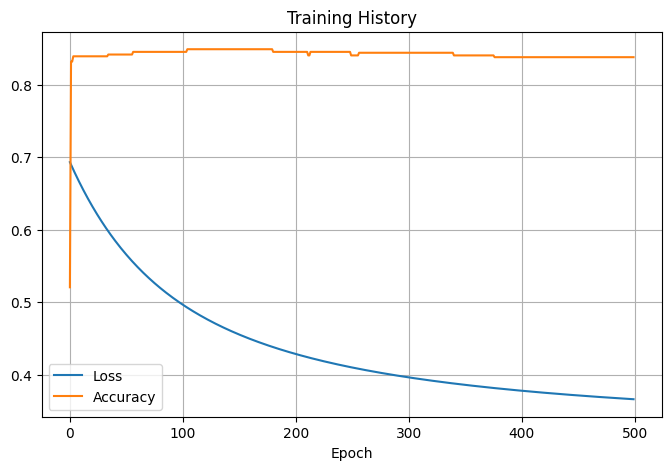


Training Evaluation
Accuracy : 0.8378
Precision: 0.8037
Recall   : 0.9110
F1-Score : 0.8540

Confusion Matrix
            Pred 0   Pred 1
Actual 0      298       95
Actual 1       38      389


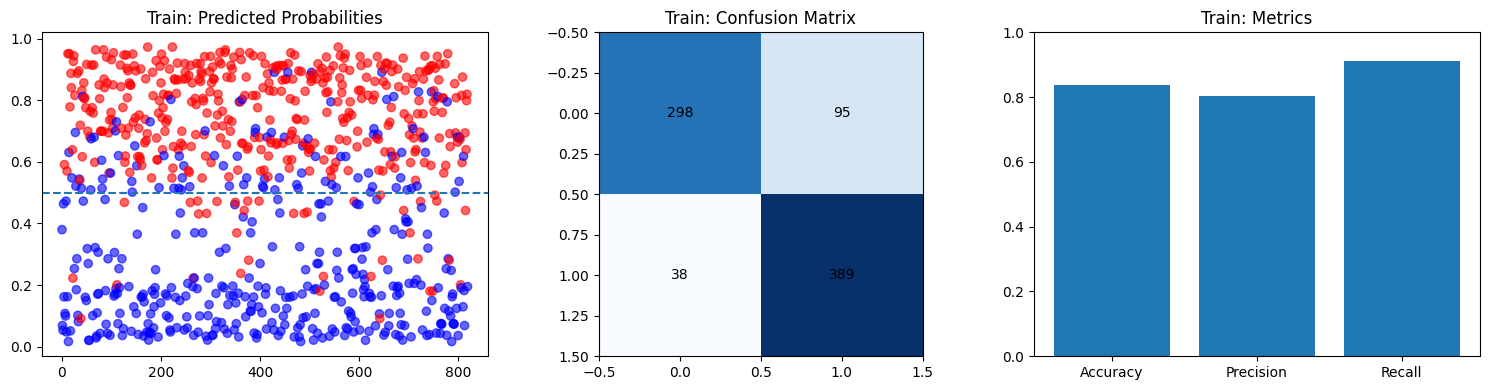


Testing Evaluation
Accuracy : 0.7854
Precision: 0.7434
Recall   : 0.8485
F1-Score : 0.7925

Confusion Matrix
            Pred 0   Pred 1
Actual 0       77       29
Actual 1       15       84


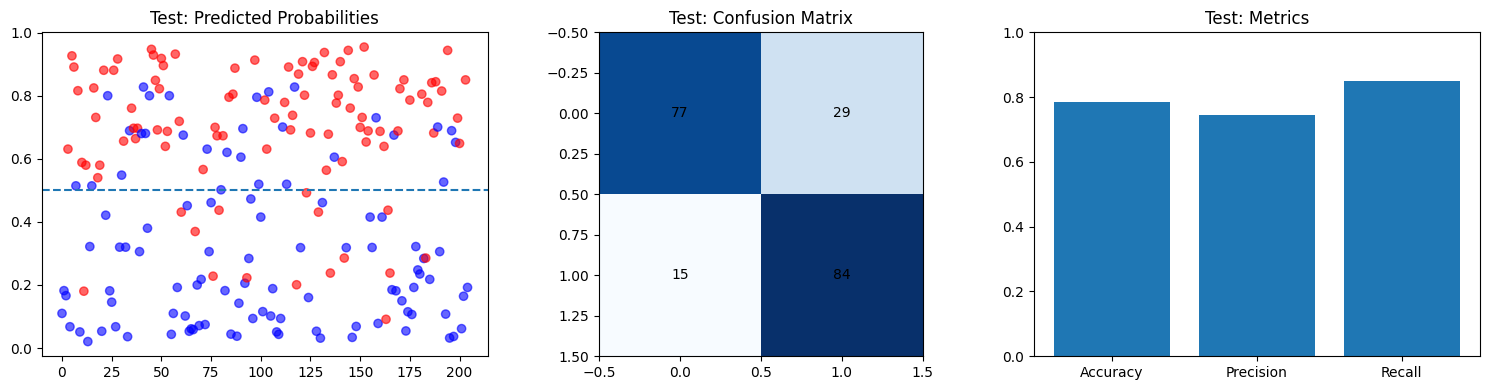

In [8]:
# Training
y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)
plot_training_history(model)
print_evaluation(y_train, y_train_pred, "Training")
plot_evaluation_row(y_train, y_train_proba, y_train_pred, "Train")


# Testing
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)
print_evaluation(y_test, y_test_pred, "Testing")
plot_evaluation_row(y_test, y_test_proba, y_test_pred, "Test")
